# <span style="color:#0b486b">  Introduction to Deep Learning Workshop (2023)</span>

***
*Speaker:*  **Dr Lim Chern Hong** \[lim.chernhong@monash.edu\]
<br/>

***

# <span style="color:#ec8428">Part 3: Recurrent Neural Network (RNN)</span>
**This handson aims to demonstrates how to apply Recurrent Neural Networks to sequence data classification. Particularly, we are going to explore how to implement an RNN for sentiment analysis with the *IMDB movie review* dataset.**

## <span style="color:#ec8428">Using RNN and IMDB dataset for sentiment analysis</span> ##

In order to implement a sentiment analysis model, we need to follow the Natural Language processing and supervised machine learning pipeline as follows:

**Step 1: Data loading and preprocessing**
   - Load and preprocess the dataset
   - Split the dataset into train, valid, and test sets.  
   
**Step 2: Build vocabulary and dictionaries**
   - Build a vocabulary to include all the words (as a corpus)   

**Step 3: Implementation of RNN architecture**
   - Define the RNN model and construct the corresponding computational graph.
   - Define the loss function and the relevant measures of performance of interest (accuracy).
    
**Step 4: Training and evaluation**
   - Train the model using mini-batches from the train set by minimizing the loss function with an optimizer.
   - Predict on the test set and access its performance.

### <span style="color:#ec8428">Step 1: Data loading and preprocessing</span> ###

We will use *tensorflow_datasets* to download and store the IMDB movie review dataset on the hard disk, we need first to install this module using pip. Please activate your TensorFlow environment and install the package *tensorflow_datasets* using:
- > <span style="color:red"> pip install tensorflow_datasets </span>

We first import the necessary modules.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

We download the imdb_reviews dataset from the tensorflow dataset: https://www.tensorflow.org/datasets/catalog/imdb_reviews. The code will download the data automatically if it is not found in the local drive.

In [2]:
tf.random.set_seed(42)

In [3]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLWS57P/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLWS57P/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLWS57P/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
datasets.keys()

dict_keys([Split('train'), Split('test'), Split('unsupervised')])

In [5]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples
print("Train size: {}".format(train_size))
print("Test size: {}".format(test_size))

Train size: 25000
Test size: 25000


Here we show a mini-batch of $5$ reviews in the training set (the content of those reviews with their labels).

In [6]:
for X_batch, y_batch in datasets["train"].batch(5).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review)
        print("Label:", label, "= Positive" if label else "= Negative")
        print("\n")

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0 = Negative


Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film

From the above sample reviews, one may observe some strange characters, for example *\<br/\>, \<br  /\>*. This is because this dataset was extracted from the HTML format. Therefore, we need to preprocess the data by removing those strange characters and splitting a review into a list of words. This is normally required in natural language processing application.

In this handson, we will use Tensorflow regular expression to process texts and strings. It is done via *tf.strings.regex_replace* with the following syntax:
- `tf.strings.regex_replace(input, pattern, rewrite, replace_global=True, name=None)`: one can specify the regular expression pattern in *pattern* and all substrings that match this pattern will be replaced by *rewrite*. Please refer to [here](https://github.com/google/re2/wiki/Syntax) for more detail of regular expressions.

We use the regular expression <span style="color:red"> <br\s*/?> </span> to find the pattern<span style="color:red"><br \[any character](one or many times) /(zero or one time)></span> and replace them by " ".

We next split the reviews in the mini-batch into words and extract the first $100$ words from each review. This would only slightly drop the performance because, for most of the reviews, we can figure out its sentiment by taking a look at its first one or two sentences.

A word boundary assertion ('b') checks if the current position in the string is a word boundary. A word boundary is where the next character is a word character and the previous character is not a word character, or vice versa.

In [7]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.regex_replace(X_batch, "<br\s*/?>", b" ")
    X_batch = tf.strings.split(X_batch)
    X_batch = X_batch[:, :100]
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [8]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(5, 100), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside.', b'Both', b'are',
         b'great', b'actors,', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history.', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline.', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'piece.', b'The', b'most', b'pathetic',
         b'scenes', b'were', b'those', b'when', b'the', b'Columbian',
         b'rebels', b'were', b'making', b'their', b'cases', b'for',
         b'revolutions.', b'Maria', b'Conchita', b'Alonso', b'appeared',
         b'phony,', b'and', b'her', b'pseudo-love', b'affair', b'with',
         b'Walken', b'was', b'nothing', b'but', b'a

### <span style="color:#ec8428">Step 2: Build vocabulary and dictionaries</span> ###

We consolidate the words in the dataset to build a vocabulary. Each word in the vocabulary will be assignerd an index for dictionary look up. The statistics is updated using mini-batches of $32$. Note that for each mini-batch, we apply the function *preprocess* to preprocess the reviews in that mini-batch and split the reviews into an array of words.

In [9]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

We now list the thirty most common words. As you can observe, the vocabulary is a list of 2-tuple of a word and its frequency.

In [10]:
vocabulary.most_common()[:30]

[(b'the', 115283),
 (b'<pad>', 94971),
 (b'a', 66401),
 (b'and', 62242),
 (b'of', 59960),
 (b'to', 52236),
 (b'is', 44410),
 (b'I', 38268),
 (b'in', 34412),
 (b'this', 27670),
 (b'that', 26056),
 (b'it', 24500),
 (b'was', 23883),
 (b'The', 19356),
 (b'movie', 16778),
 (b'with', 16744),
 (b'as', 16236),
 (b'for', 15795),
 (b'but', 13815),
 (b'on', 12949),
 (b'film', 12530),
 (b'have', 11866),
 (b'are', 11325),
 (b'not', 10846),
 (b'be', 10186),
 (b'you', 9813),
 (b'his', 9748),
 (b'one', 9299),
 (b'by', 8776),
 (b'an', 8774)]

In [11]:
len(vocabulary)

150841

We now create a truncated vocabulary of the $10,000$ most common words.

In [12]:
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

We now create the dictionary *word_to_id* which allows us to quickly find the id for a given word.

In [13]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
print(list(word_to_id.items())[0:10])

[(b'the', 0), (b'<pad>', 1), (b'a', 2), (b'and', 3), (b'of', 4), (b'to', 5), (b'is', 6), (b'I', 7), (b'in', 8), (b'this', 9)]


The following code aims to find a list of indices for the words in a sentence. Note that because the word "faaaantastic" is not in the list, it is returned None.

In [14]:
[word_to_id.get(word) for word in b"This movie was faaaantastic".split()]

[31, 14, 12, None]

Next, we create a lookup table that enables us to return 2D tensor of indices from given sentences. It is very important to note that because we limit to consider the vocabulary of the most $10000$ common words, for a given sentence in the training or testing set, some words might be out of the list. To address this issue, we set the number of *out of vocabulary* bucket $num\_oov\_buckets = 1000$. Therefore, a word in *out of the vocabulary* will be mapped to one of *out of bucket* index.

Note that you now can imagine that we have an extended vocabulary with the vocabulary size to be equal to $vocab\_size + num\_oov\_buckets= 11,000$.

In [15]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

As you can see, although the word "faaaaantastic" is not in the vocabulary, it is now mapped to the index $10791$ in the out of vocabulary bucket.

In [16]:
table.lookup(tf.constant([b"This movie was faaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   31,    14,    12, 10791]])>

The function *encode_words* returns the word indices for the words in the sentences in a mini-batch.

In [17]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In the following code, we first apply the function *preprocess* to preprocess the training set and then apply the function *encode_words* to convert words to their indices.

In [18]:
train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [19]:
for X_batch, y_batch in train_set.take(2):
    print(X_batch.shape)
    print(y_batch.shape)

(32, 100)
(32,)
(32, 100)
(32,)


### <span style="color:#ec8428">Step 3: Implementation of RNN Architecture</span> ###

Here, we implement an RNN architecture by stacking of two RNN cells. The input $x$ has the shape $batch\_size \times timesteps$. The embedding layer takes the input $x$ and transforms it to 3D tensor $batch\_size \times timesteps \times embed\_size$. When declaring an embedding layer, we need to specify vocabulary size (extended one with the size $vocab\_size + num\_oov\_buckets$, and the $embed\_size$. TF Keras will automatically infer the $timesteps$. The RNN architecture can be implemented in 2 ways:

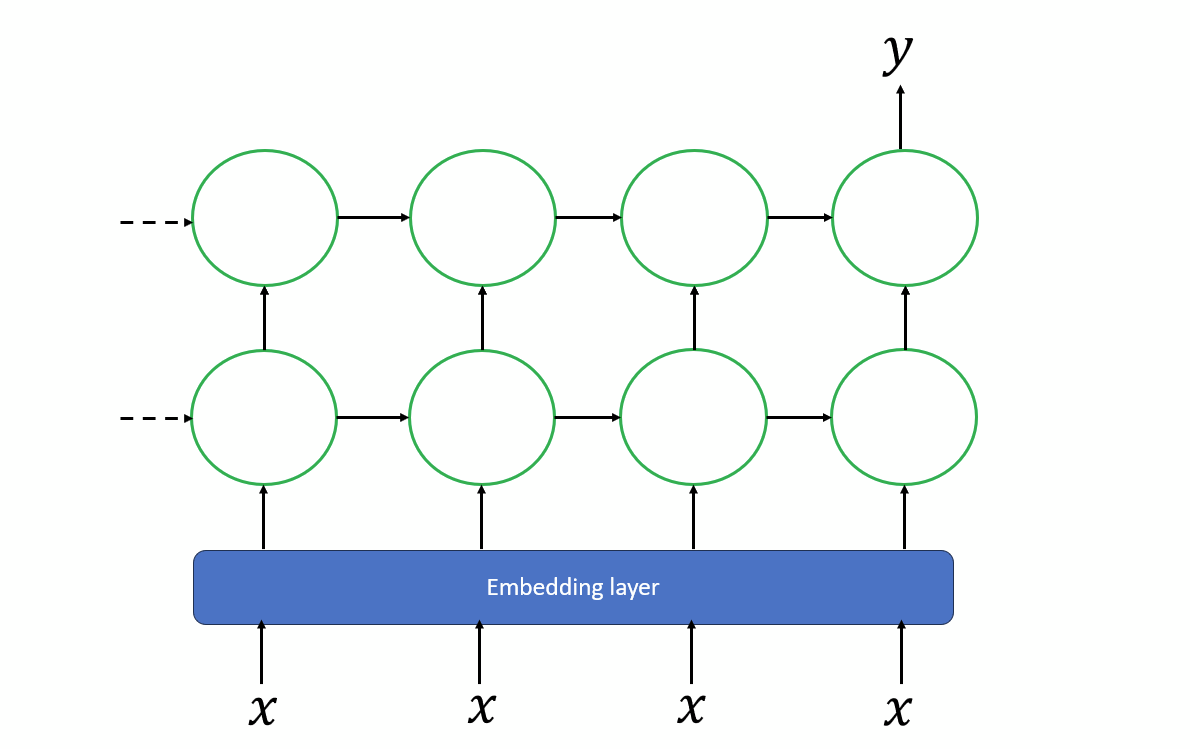

**1. Using Sequential method (Train using simpleRNN)**

In [20]:
embed_size = 64
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, #this specifies that padded 0(s) will be ignored during training
                           input_shape=[None]),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=2)

Epoch 1/2
781/781 [==============================] - 76s 94ms/step - loss: 0.6958 - accuracy: 0.5230
Epoch 2/2
781/781 [==============================] - 71s 91ms/step - loss: 0.6667 - accuracy: 0.5865


**2. Using Functional API (Train using LSTM)**

In [21]:
embed_size = 64
x = tf.keras.Input(shape=[None], dtype="int64")
print(x.shape)
h = tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(x)
print(h.shape)
h = tf.keras.layers.LSTM(embed_size, return_sequences=True)(h)
print(h.shape)
h = tf.keras.layers.LSTM(64)(h)
print(h.shape)
h = tf.keras.layers.Dense(1, activation="sigmoid")(h)
rnn_model = tf.keras.models.Model(inputs = x, outputs= h)

rnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = rnn_model.fit(train_set, steps_per_epoch=train_size // 32, epochs=2)

(None, None)
(None, None, 64)
(None, None, 64)
(None, 64)
Epoch 1/2
781/781 [==============================] - 110s 136ms/step - loss: 0.5030 - accuracy: 0.7480
Epoch 2/2
781/781 [==============================] - 108s 138ms/step - loss: 0.3272 - accuracy: 0.8681


We now evaluate our model on the test set.

In [22]:
test_set = datasets["test"].repeat(1).batch(32).map(preprocess)
test_set = test_set.map(encode_words).prefetch(1)

In [23]:
model.evaluate(test_set)

782/782 [==============================] - 20s 25ms/step - loss: 0.6334 - accuracy: 0.6834


[0.6333718299865723, 0.6833599805831909]

### <span style="color:#ec8428"> Try it yourself </span>

**<span style="color:red">Exercise 1:</span>** Replace the SimpleRNN cells and LSTM with another variation of RNN named GRU compare the results.

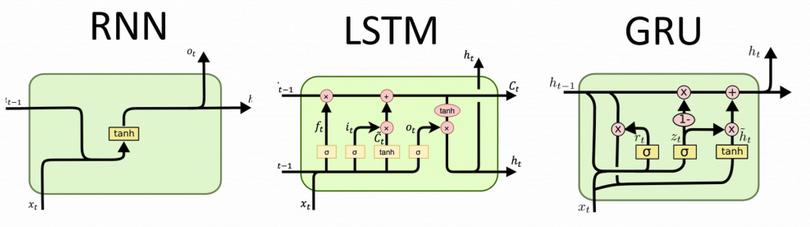

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>